# Named Entity Recognition using LSTM

## First with word embedding

In [107]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

##### Download data from https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus#ner_dataset.csv

In [108]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [109]:
data = data.fillna(method="ffill")
data.tail(5)

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [110]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [111]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [112]:
tags

['I-art',
 'I-gpe',
 'B-nat',
 'I-eve',
 'I-nat',
 'I-org',
 'B-per',
 'B-gpe',
 'B-art',
 'I-geo',
 'O',
 'B-geo',
 'B-eve',
 'I-tim',
 'B-tim',
 'I-per',
 'B-org']

In [113]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [114]:
word2idx["Obama"]

27489

In [115]:
tag2idx["B-geo"]

11

#### Parse data to extract sentences as (word, pos_tag, ner_tag)

In [116]:
sent_group = data.groupby("Sentence #").apply(lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                                                     s["POS"].values.tolist(),
                                                                                     s["Tag"].values.tolist())])
sentences = [s for s in sent_group]

##### Create X and y with padding - 0 for X  and 'O' tag for y

This data follows IOB tagging scheme, O means token belong to no chunk.

In [117]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


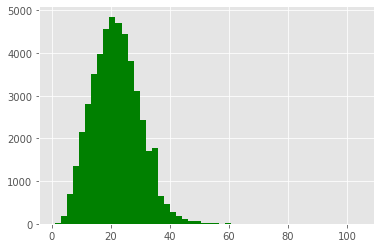

In [158]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50, color='green')
plt.show()

In [22]:
max_len = 75

from tensorflow.keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [23]:
X[0], y[0]

(array([ 3201, 21110, 26786, 15265, 31585, 31720,   456, 32255, 24999,
         4687, 20500,  7987, 19919,  6170,  3837,  4687,  4234, 21110,
        22375, 34556, 27284, 23812, 32282,  1910,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]),
 array([10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10,
        10,  7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10]))

##### Make y as categorical - One-hot vector

In [24]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [25]:
y[0][0], y[0][6]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       dtype=float32))

##### Train Test Split

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

##### CRF can be used in place of softmax. 

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Lambda
#from tensorflow.contrib import CRF

##### Define Model

In [28]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
out = Dense(n_tags, activation="softmax")(model)
# crf = CRF(n_tags)  # CRF layer
# out = crf(model)  # output
model = Model(input, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 75, 20)            703600    
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 100)           28400     
_________________________________________________________________
time_distributed (TimeDistri (None, 75, 50)            5050      
_________________________________________________________________
dense_1 (Dense)              (None, 75, 17)            867       
Total params: 737,917
Trainable params: 737,917
Non-trainable params: 0
_________________________________________________________________


##### Train Model

In [29]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
1214/1214 [==============================] - 108s 85ms/step - loss: 0.1177 - accuracy: 0.9040 - val_loss: 0.0501 - val_accuracy: 0.9515
Epoch 2/5
1214/1214 [==============================] - 107s 88ms/step - loss: 0.0362 - accuracy: 0.9633 - val_loss: 0.0357 - val_accuracy: 0.9637
Epoch 3/5
1214/1214 [==============================] - 115s 95ms/step - loss: 0.0261 - accuracy: 0.9726 - val_loss: 0.0336 - val_accuracy: 0.9662
Epoch 4/5
1214/1214 [==============================] - 114s 94ms/step - loss: 0.0218 - accuracy: 0.9766 - val_loss: 0.0329 - val_accuracy: 0.9668
Epoch 5/5
1214/1214 [==============================] - 114s 94ms/step - loss: 0.0190 - accuracy: 0.9790 - val_loss: 0.0340 - val_accuracy: 0.9668


##### Evaluate Model

In [30]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_test, verbose=1)

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

150/150 [==============================] - 3s 14ms/step
F1-score: 79.9%


In [31]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.00      0.00      0.00        39
         eve       0.62      0.32      0.43        31
         geo       0.82      0.88      0.84      3710
         gpe       0.96      0.94      0.95      1538
         nat       1.00      0.15      0.26        20
         org       0.61      0.67      0.64      2027
         per       0.73      0.70      0.71      1604
         tim       0.87      0.84      0.85      2008

   micro avg       0.79      0.81      0.80     10977
   macro avg       0.70      0.56      0.59     10977
weighted avg       0.79      0.81      0.80     10977



##### Prediction

In [32]:
i = 1000
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))


Word           ||True ||Pred
Officials      : O     O
say            : O     O
the            : O     O
ship           : O     O
,              : O     O
the            : O     O
Al             : B-org B-org
Marwa          : I-org I-org
,              : O     O
was            : O     O
carrying       : O     O
some           : O     O
3,000          : O     O
tons           : O     O
of             : O     O
aid            : O     O
when           : O     O
it             : O     O
was            : O     O
stopped        : O     O
by             : O     O
the            : O     O
Israeli        : B-gpe B-gpe
navy           : O     O
.              : O     O


 # Enhancing LSTMs with character embeddings

In [132]:
max_len_char = 10

In [133]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [134]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

In [135]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [136]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

98


##### Character Embedding

In [137]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [138]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
X_char[0]

array([[34, 90, 93, 44, 80, 99, 70,  3, 80,  0],
       [93, 62,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 33, 58, 93, 70, 80, 36, 88, 99, 36],
       [90, 99, 45, 33,  0,  0,  0,  0,  0,  0],
       [58, 99, 88, 68, 90, 33,  3,  0,  0,  0],
       [36, 90, 88, 93, 44, 24, 90,  0,  0,  0],
       [72, 93, 70,  3, 93, 70,  0,  0,  0,  0],
       [36, 93,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7, 88, 93, 36, 33, 80, 36,  0,  0,  0],
       [36, 90, 33,  0,  0,  0,  0,  0,  0,  0],
       [55, 99, 88,  0,  0,  0,  0,  0,  0,  0],
       [89, 70,  0,  0,  0,  0,  0,  0,  0,  0],
       [53, 88, 99, 87,  0,  0,  0,  0,  0,  0],
       [99, 70,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 33, 58, 99, 70,  3,  0,  0,  0,  0],
       [36, 90, 33,  0,  0,  0,  0,  0,  0,  0],
       [55, 89, 36, 90,  3, 88, 99, 55, 99, 60],
       [93, 62,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 88, 89, 36, 89, 80, 90,  0,  0,  0],
       [36, 88, 93, 93,  7, 80,  0,  0,  0,  0],
       [62, 88, 93, 

In [139]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [140]:
from sklearn.model_selection import train_test_split

X_word_train, X_word_test, y_train, y_test = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_train, X_char_test, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [141]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


##### Define Model

In [142]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [143]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 10)   1000        input_20[0][0]                   
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       703620      input_19[0][0]                   
____________________________________________________________________________________________

##### Train Model

In [144]:
history = model.fit([X_word_train,
                     np.array(X_char_train).reshape((len(X_char_train), max_len, max_len_char))],
                    np.array(y_train).reshape(len(y_train), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


Epoch 1/10
1214/1214 [==============================] - 205s 164ms/step - loss: 0.1445 - acc: 0.8716 - val_loss: 0.0624 - val_acc: 0.9396
Epoch 2/10
1214/1214 [==============================] - 217s 179ms/step - loss: 0.0481 - acc: 0.9535 - val_loss: 0.0396 - val_acc: 0.9605
Epoch 3/10
1214/1214 [==============================] - 222s 183ms/step - loss: 0.0350 - acc: 0.9657 - val_loss: 0.0345 - val_acc: 0.9654
Epoch 4/10
1214/1214 [==============================] - 223s 183ms/step - loss: 0.0299 - acc: 0.9700 - val_loss: 0.0322 - val_acc: 0.9672
Epoch 5/10
1214/1214 [==============================] - 219s 180ms/step - loss: 0.0272 - acc: 0.9721 - val_loss: 0.0316 - val_acc: 0.9675
Epoch 6/10
1214/1214 [==============================] - 219s 180ms/step - loss: 0.0254 - acc: 0.9736 - val_loss: 0.0308 - val_acc: 0.9681
Epoch 7/10
1214/1214 [==============================] - 2882s 2s/step - loss: 0.0239 - acc: 0.9748 - val_loss: 0.0302 - val_acc: 0.9690
Epoch 8/10
1214/1214 [==============

##### Predict Model

In [155]:
y_pred = model.predict([X_word_test,
                        np.array(X_char_test).reshape((len(X_char_test),
                                                     max_len, max_len_char))])

In [157]:
i = 1000
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_test[i], y_test[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
The            : O     O
US             : B-org B-org
Government     : I-org I-org
is             : O     O
also           : O     O
a              : O     O
major          : O     O
revenue        : O     O
source         : O     O
for            : O     O
Tuvalu         : B-org B-org
because        : O     O
of             : O     O
payments       : O     O
from           : O     O
a              : O     O
1988           : B-tim B-tim
treaty         : O     O
on             : O     O
fisheries      : O     O
.              : O     O
